In [37]:
import pandas as pd
import numpy as np
import xgboost as xgb
import graphviz
import matplotlib.pyplot as plt
from xgboost import plot_tree


from sklearn.model_selection import train_test_split #split data into training and test sets
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer # for scoring
from sklearn.model_selection import GridSearchCV #Cross validation
from sklearn.metrics import confusion_matrix #create confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay #drwas the confusion matrix




Loading the original dataset

In [3]:
df = pd.read_csv('../Data/Telco_customer_churn.csv')            # Load the dataset

Some columns contain data from exit interviews which should not be used for prediction since this data is only available for customers who have already left and will therefore lead to false "perfect" predictions

In [4]:
df.drop(['Churn Label', 'Churn Score', 'CLTV', 'Churn Reason'], # dropping selected columns with 
        axis=1, inplace=True)                                   # Set axis= 0 to remove rows, or axis=1 to remove columns, inplace=True ensures changes are applied to the same dataframe instead of returning a new one

In addition to removing the columns which contain exit interview data, there are further columns which are not useful for prediciton and are better removed from the dataset. For example "Count", "Country" and "State" all have the same value in the dataset, and so no predictive value. In addition, "CustomerID" is different for each customer and also does not have any predictive value. Finally "Lat Long" contains data which is already represented in separate columns "Latitude" and "Longitude" and is therefore undeccesary.

In [5]:
df.drop(['Count', 'State', 'Country', 'Lat Long', 'CustomerID'], axis=1, inplace=True)

Additional treatmetn of the data is now desireable in the form of removing the whitespace in the city names. This is only necessary for the purposes of drawing the tree and would typically not affect the XGBoost algorithm

In addition we will elliminate the whitespace in the column names

In [6]:
df['City'] = df['City'].str.replace(' ', '_')
df.columns = df.columns.str.replace(' ', '_')

# Itentify Missing Data

In [7]:
df.dtypes

City                     str
Zip_Code               int64
Latitude             float64
Longitude            float64
Gender                   str
Senior_Citizen           str
Partner                  str
Dependents               str
Tenure_Months          int64
Phone_Service            str
Multiple_Lines           str
Internet_Service         str
Online_Security          str
Online_Backup            str
Device_Protection        str
Tech_Support             str
Streaming_TV             str
Streaming_Movies         str
Contract                 str
Paperless_Billing        str
Payment_Method           str
Monthly_Charges      float64
Total_Charges            str
Churn_Value            int64
dtype: object

In [8]:
# THis will give an error but will demonstrate what the problem with the Total Charges data is, uncomment to verify
#df['Total_Charges'] = pd.to_numeric(df['Total_Charges'])

Find how many rows have the missing value

In [9]:
len(df.loc[df['Total_Charges'] == ' '])

11

Therefore only 11 rows have these missing valeus

In [10]:
df.loc[df['Total_Charges'] == ' ']

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
2234,San_Bernardino,92408,34.084909,-117.258107,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,0
2438,Independence,93526,36.869584,-118.189241,Male,No,No,No,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,0
2568,San_Mateo,94401,37.590421,-122.306467,Female,No,Yes,No,0,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,0
2667,Cupertino,95014,37.306612,-122.080621,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,0
2856,Redcrest,95569,40.363446,-123.835041,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,0
4331,Los_Angeles,90029,34.089953,-118.294824,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,0
4687,Sun_City,92585,33.739412,-117.173334,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,0
5104,Ben_Lomond,95005,37.078873,-122.090386,Female,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,0
5719,La_Verne,91750,34.144703,-117.770299,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,0
6772,Bell,90201,33.970343,-118.171368,Female,No,Yes,Yes,0,Yes,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,0


"Tenure Months" is 0 for these peeople which explains why they haven't been charged. In addition to setting missing values to 0 being the default for XGBoost, this means it will also make sense numerically to fill in these values with zeros.

In [11]:
df.loc[(df['Total_Charges'] == ' '), 'Total_Charges'] = '0' ## We specify that we want all the rows in which Total Charges has a blank, and only select the Total Chares column, replacing it with zero. The zero needs to be in quatitions since the column is dtype string

Verify the replacement by looking at all the rows where Tenre Months is zero. Looking this ways is better because there might be people who have longer tenure but still have zeros total charges

In [12]:
df.loc[df['Tenure_Months'] == 0]

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
2234,San_Bernardino,92408,34.084909,-117.258107,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,0,0
2438,Independence,93526,36.869584,-118.189241,Male,No,No,No,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,0,0
2568,San_Mateo,94401,37.590421,-122.306467,Female,No,Yes,No,0,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,0,0
2667,Cupertino,95014,37.306612,-122.080621,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,0,0
2856,Redcrest,95569,40.363446,-123.835041,Female,No,Yes,No,0,No,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,0,0
4331,Los_Angeles,90029,34.089953,-118.294824,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,0,0
4687,Sun_City,92585,33.739412,-117.173334,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,0,0
5104,Ben_Lomond,95005,37.078873,-122.090386,Female,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,0,0
5719,La_Verne,91750,34.144703,-117.770299,Male,No,Yes,Yes,0,Yes,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,0,0
6772,Bell,90201,33.970343,-118.171368,Female,No,Yes,Yes,0,Yes,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,0,0


Everything appears to be correct, however the dtype is still string which is not good for XGBoost which only accepts int, float and bool. We need to convert the column to numeric.

In [13]:
df['Total_Charges'] = pd.to_numeric(df['Total_Charges'])
df.dtypes

City                     str
Zip_Code               int64
Latitude             float64
Longitude            float64
Gender                   str
Senior_Citizen           str
Partner                  str
Dependents               str
Tenure_Months          int64
Phone_Service            str
Multiple_Lines           str
Internet_Service         str
Online_Security          str
Online_Backup            str
Device_Protection        str
Tech_Support             str
Streaming_TV             str
Streaming_Movies         str
Contract                 str
Paperless_Billing        str
Payment_Method           str
Monthly_Charges      float64
Total_Charges        float64
Churn_Value            int64
dtype: object

Great, now we want to make sure to replace all the other whitespaces in the other columns with underscores (only necessary for ploting the tree). The rest of the columns which are a string will be dealt with later through One-Hot-Encoding

In [14]:
df.replace(' ', '_', regex=True, inplace=True)

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
0,Los_Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,108.15,1
1,Los_Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,151.65,1
2,Los_Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic_check,99.65,820.50,1
3,Los_Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic_check,104.80,3046.05,1
4,Los_Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,No,Yes,Yes,Month-to-month,Yes,Bank_transfer_(automatic),103.70,5036.30,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Landers,92285,34.341737,-116.539416,Female,No,No,No,72,Yes,...,No_internet_service,No_internet_service,No_internet_service,No_internet_service,Two_year,Yes,Bank_transfer_(automatic),21.15,1419.40,0
7039,Adelanto,92301,34.667815,-117.536183,Male,No,Yes,Yes,24,Yes,...,Yes,Yes,Yes,Yes,One_year,Yes,Mailed_check,84.80,1990.50,0
7040,Amboy,92304,34.559882,-115.637164,Female,No,Yes,Yes,72,Yes,...,Yes,No,Yes,Yes,One_year,Yes,Credit_card_(automatic),103.20,7362.90,0
7041,Angelus_Oaks,92305,34.167800,-116.864330,Female,No,Yes,Yes,11,No,...,No,No,No,No,Month-to-month,Yes,Electronic_check,29.60,346.45,0


# Format the Data

## Split the data

First the dataset needs to be split in two parts to form the dependent variables used to make the classification and the independent variables, i.e. the variable we want to predict.

By convention X will be the columns of data used to make the classification and y will be the column we would like to predict, in this case Churn Value

Missing variables are dealt with before splitting the data to ensure that any row removal would ensure the data is still matching in all columns.

In [15]:
X = df.drop('Churn_Value', axis=1).copy() # copy() used to copy the data so that the original dataframe is not modified.
X.head()

,City,Zip_Code,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,...,Online_Backup,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges
0,Los_Angeles,90003,33.964131,-118.272783,Male,No,No,No,2,Yes,...,Yes,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,108.15
1,Los_Angeles,90005,34.059281,-118.307420,Female,No,No,Yes,2,Yes,...,No,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,151.65
2,Los_Angeles,90006,34.048013,-118.293953,Female,No,No,Yes,8,Yes,...,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic_check,99.65,820.50
3,Los_Angeles,90010,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,...,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic_check,104.80,3046.05
4,Los_Angeles,90015,34.039224,-118.266293,Male,No,No,Yes,49,Yes,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank_transfer_(automatic),103.70,5036.30


In [16]:
y = df['Churn_Value'].copy()
y.head()

0    1
1    1
2    1
3    1
4    1
Name: Churn_Value, dtype: int64

## One-Hot Encoding

The data should be in the following format as described in the original source:

- City              : Category
- Zip_Code          : Category
- Latitude          : float
- Longitude         : float
- Gender            : Category
- Senior_Citizen    : Category
- Partner           : Category
- Dependents        : Category
- Tenure_Months     : float
- Phone_Service     : Category
- Multiple_Lines    : Category
- Internet_Service  : Category
- Online_Security   : Category
- Online_Backup     : Category
- Device_Protection : Category
- Tech_Support      : Category
- Streaming_TV      : Category
- Streaming_Movies  : Category
- Contract          : Category
- Paperless_Billing : Category
- Payment_Method    : Category
- Monthly_Charges   : float
- Total_Charges     : float


Currenty, the categories are as follows

In [17]:
X.dtypes

City                     str
Zip_Code               int64
Latitude             float64
Longitude            float64
Gender                   str
Senior_Citizen           str
Partner                  str
Dependents               str
Tenure_Months          int64
Phone_Service            str
Multiple_Lines           str
Internet_Service         str
Online_Security          str
Online_Backup            str
Device_Protection        str
Tech_Support             str
Streaming_TV             str
Streaming_Movies         str
Contract                 str
Paperless_Billing        str
Payment_Method           str
Monthly_Charges      float64
Total_Charges        float64
dtype: object

There fore the Latitude, Longitude, Monthy_Charges and Total_Charges are all float64 as needed. However, the rest of the columns which need to be categorical are currently strings. They also need to be inspected to ensure they only contain reasonable values. Furthermore, since XGBoost does not natively support categoriacal values, they will need to be changed and modified using One-Hot Encoding, i.e. conver them from one column with multiple categories to multiple columns with binary values.

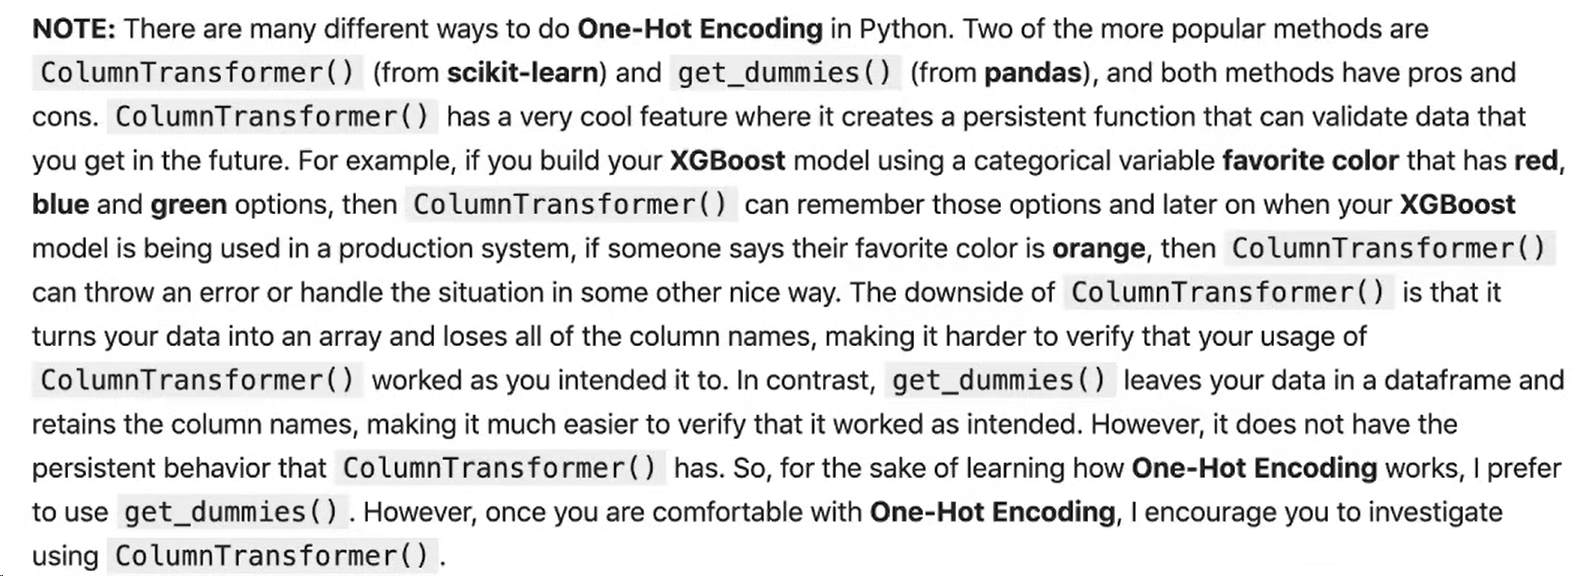

In [18]:

X_encoded = pd.get_dummies(X, columns=['City',
                                       'Gender',
                                       'Senior_Citizen',
                                       'Partner',
                                       'Dependents',
                                       'Phone_Service',
                                       'Multiple_Lines',
                                       'Internet_Service',
                                       'Online_Security',
                                       'Online_Backup',
                                       'Device_Protection',
                                       'Tech_Support', 
                                       'Streaming_TV',
                                       'Streaming_Movies',
                                       'Contract',
                                       'Paperless_Billing',
                                       'Payment_Method', ])

X_encoded.head()

,Zip_Code,Latitude,Longitude,Tenure_Months,Monthly_Charges,Total_Charges,City_Acampo,City_Acton,City_Adelanto,City_Adin,...,Streaming_Movies_Yes,Contract_Month-to-month,Contract_One_year,Contract_Two_year,Paperless_Billing_No,Paperless_Billing_Yes,Payment_Method_Bank_transfer_(automatic),Payment_Method_Credit_card_(automatic),Payment_Method_Electronic_check,Payment_Method_Mailed_check
0,90003,33.964131,-118.272783,2,53.85,108.15,False,False,False,False,...,False,True,False,False,False,True,False,False,False,True
1,90005,34.059281,-118.307420,2,70.70,151.65,False,False,False,False,...,False,True,False,False,False,True,False,False,True,False
2,90006,34.048013,-118.293953,8,99.65,820.50,False,False,False,False,...,True,True,False,False,False,True,False,False,True,False
3,90010,34.062125,-118.315709,28,104.80,3046.05,False,False,False,False,...,True,True,False,False,False,True,False,False,True,False
4,90015,34.039224,-118.266293,49,103.70,5036.30,False,False,False,False,...,True,True,False,False,False,True,True,False,False,False


Finally, verify that the y column only contains 1s and 0s

In [19]:
y.unique()

array([1, 0])

# Build A Preliminary XGBoost model

To build the XGBoost model, we need to split the data into training and testing sets.

First, lets observe how balanced the data is by dividing the number of people who left the company, where y=1 by the total number of people in the dataset

In [20]:
sum(y)/len(y)

0.2653698707936959

Only ~27% of the people in the dataset left the company. Because of this, splitting the dataset should be done using stratification in order to maintain the same percentage of people who left the company in both the training and testing sets

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=42, stratify=y) # setting the stratify=y indicates that we want to stratify based on the ratio in the y dataframe, i.e. based ont he values we want to classify

In [22]:
# Check 
sum(y_train)/len(y_train)

0.2654297614539947

In [25]:
sum(y_test)/len(y_test)

0.26519023282226006

Instead of determining the optimal number of trees with cross validation, we will use early stopping to stop building the trees when they no longer improve the situation.

In [26]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic',
                             missing=None,
                             early_stopping_rounds=10, # define the number of trees to build after the predicions stop improving before stopping
                             eval_metric='aucpr',      # auc is used as the way of determing when the predictions stop improving 
                             seed=42) # binary logistic objective is used for classification because XGBoost uses logistir regression approach to evaluate performance;
clf_xgb.fit(X_train,
            y_train,
            verbose=True,
            eval_set = [(X_test, y_test)]) # pass the testing set for the performance calculations

[0]	validation_0-aucpr:0.64484
[1]	validation_0-aucpr:0.65281
[2]	validation_0-aucpr:0.66059
[3]	validation_0-aucpr:0.65424
[4]	validation_0-aucpr:0.66064
[5]	validation_0-aucpr:0.66153
[6]	validation_0-aucpr:0.66547
[7]	validation_0-aucpr:0.66499
[8]	validation_0-aucpr:0.66667
[9]	validation_0-aucpr:0.66309
[10]	validation_0-aucpr:0.66416
[11]	validation_0-aucpr:0.66180
[12]	validation_0-aucpr:0.66855
[13]	validation_0-aucpr:0.66674
[14]	validation_0-aucpr:0.66577
[15]	validation_0-aucpr:0.66509
[16]	validation_0-aucpr:0.66491
[17]	validation_0-aucpr:0.66553
[18]	validation_0-aucpr:0.66463
[19]	validation_0-aucpr:0.66598
[20]	validation_0-aucpr:0.66601
[21]	validation_0-aucpr:0.66762
[22]	validation_0-aucpr:0.66726


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",10
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes fr

The XGBoost classification model is build and now it needs to be tested. The performance will be evaluated the testing dataset down the model and drawing a confusion matrix.

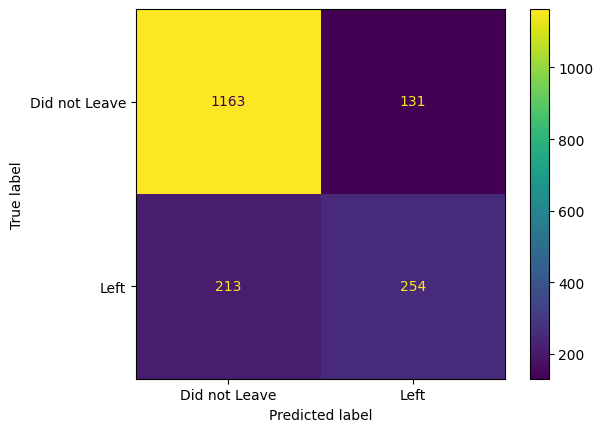

In [27]:
ConfusionMatrixDisplay.from_estimator(clf_xgb,
                      X_test,
                      y_test,
                      values_format='d',
                      display_labels=["Did not Leave", "Left"])

In the confusion matrix we see that 1294 people did not leave and XGBoost correctly classified 1163 (90%) of them, while from the 467 people that left, XGBoost correctly classified only 254 (54%). Thisis partially due to the imballanced data. Because people leaving costs the company a lot of money, it would be better to capture correctly more of the people that left. To do this, the scale_pos_weight parameter in XGBoost can be used to help with the imbalanced data. So lets try to improve the predictions using Cross Validation

In essence scale_pos_weight adds a penalyt for inccorectly classifying the miniority class

# Optimise parameters using Cross Validation and GridSearch()

XGBoost has a lot of hyperparameters that need to be manually configured and are not determined by XGBoost itsef. These include max_depht, maximum tree depth; learning_rate, the learning rate (eta); gamma, the parameter that encourages pruning; and reg_lambda, the regularization parameter lambda.

We will try to find the optimum parameters using the Testing dataset.

Since there are many parameters to optimise, we will use GridSearchCV()

In [28]:
## Round 1
param_grid = {
    'max_depth' : [3,4,5],
    'learning_rate' : [0.1, 0.01, 0.05],
    'gamma' : [0, 0.25, 1.0],
    'reg_lambda' : [0, 1.0, 10.0],
    'scale_pos_weight' : [1,3,5] #XGBoost recommends sum(negative instances)/sum(positive instances)
}

optimal_params = GridSearchCV(
    estimator=xgb.XGBClassifier(objective='binary:logistic',
                                seed=42,
                                subsample=0.9,            # Using only random 90% subset of the data per tree to speed up calculations
                                colsample_bytree=0.5),    # Using only 50% of the columns per tree to speed up calculations
    param_grid= param_grid,
    scoring='roc_auc',
    verbose=2,
    n_jobs=10,
    cv=3 # Using 3 fold cross valudation

)

In [29]:
clf_xgb_op = xgb.XGBClassifier(objective='binary:logistic',
                             missing=None,
                             early_stopping_rounds=10, # define the number of trees to build after the predicions stop improving before stopping
                             eval_metric='aucpr',      # auc is used as the way of determing when the predictions stop improving 
                             seed=42,
                             gamma=0.25,
                             learning_rate=0.1,
                             max_depth=4,
                             reg_lambda=10,
                             scale_pos_weight=3,
                             subsample=0.9,
                             colsample_bytree=0.5) # binary logistic objective is used for classification because XGBoost uses logistir regression approach to evaluate performance;
clf_xgb_op.fit(X_train,
            y_train,
            verbose=True,
            eval_set = [(X_test, y_test)]) # pass the testing set for the performance calculations

[0]	validation_0-aucpr:0.54568
[1]	validation_0-aucpr:0.57012
[2]	validation_0-aucpr:0.62310
[3]	validation_0-aucpr:0.62919
[4]	validation_0-aucpr:0.63401
[5]	validation_0-aucpr:0.63516
[6]	validation_0-aucpr:0.63687
[7]	validation_0-aucpr:0.63848
[8]	validation_0-aucpr:0.63844
[9]	validation_0-aucpr:0.63843
[10]	validation_0-aucpr:0.63736
[11]	validation_0-aucpr:0.63787
[12]	validation_0-aucpr:0.64818
[13]	validation_0-aucpr:0.64558
[14]	validation_0-aucpr:0.65317
[15]	validation_0-aucpr:0.65146
[16]	validation_0-aucpr:0.65067
[17]	validation_0-aucpr:0.64982
[18]	validation_0-aucpr:0.64991
[19]	validation_0-aucpr:0.65623
[20]	validation_0-aucpr:0.65576
[21]	validation_0-aucpr:0.65651
[22]	validation_0-aucpr:0.65720
[23]	validation_0-aucpr:0.65565
[24]	validation_0-aucpr:0.65337
[25]	validation_0-aucpr:0.65291
[26]	validation_0-aucpr:0.65298
[27]	validation_0-aucpr:0.65229
[28]	validation_0-aucpr:0.65448
[29]	validation_0-aucpr:0.65487
[30]	validation_0-aucpr:0.65840
[31]	validation_0-

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.5
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",10
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes fro

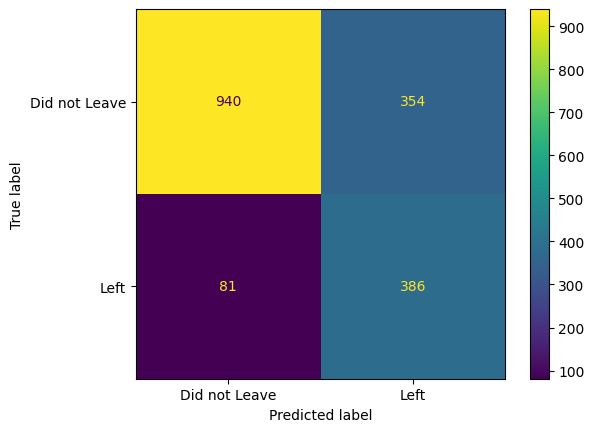

In [30]:
ConfusionMatrixDisplay.from_estimator(clf_xgb_op,
                      X_test,
                      y_test,
                      values_format='d',
                      display_labels=["Did not Leave", "Left"])

Draw the tree

[0]	validation_0-aucpr:0.54568


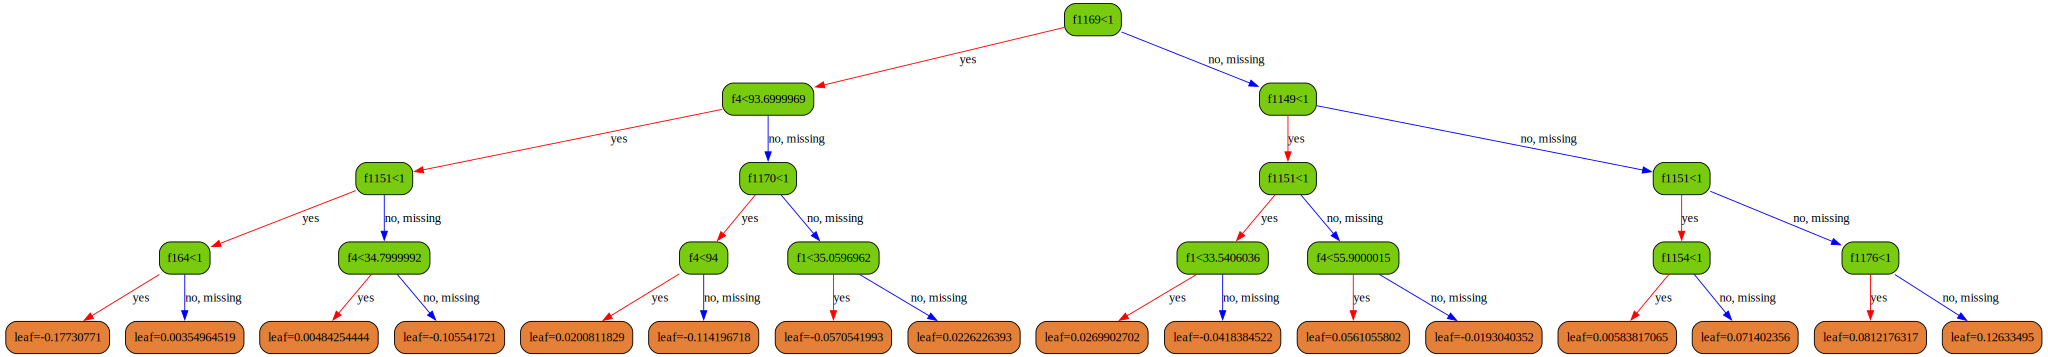

In [ ]:
clf_xgb_op = xgb.XGBClassifier(objective='binary:logistic',
                             missing=None,
                             early_stopping_rounds=10, # define the number of trees to build after the predicions stop improving before stopping
                             eval_metric='aucpr',      # auc is used as the way of determing when the predictions stop improving 
                             seed=42,
                             gamma=0.25,
                             learning_rate=0.1,
                             max_depth=4,
                             reg_lambda=10,
                             scale_pos_weight=3,
                             subsample=0.9,
                             colsample_bytree=0.5,
                             n_estimators=1) # we set this to 1 in order to build one tree, so we can get gain, cover etc.

clf_xgb_op.fit(X_train,
            y_train,
            verbose=True,
            eval_set = [(X_test, y_test)]) # pass the testing set for the performance calculations


# bst = clf_xgb_op.get_booster()
# for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'totat_cover'):
#     print('%s:' % importance_type, bst.get_score(importance_type=importance_type))

node_params = {'shape' : 'box',
               'style' : 'filled, rounded',
               'fillcolor': '#78cbe' }


leaf_params = {'shape' : 'box',
               'style' : 'filled, rounded',
               'fillcolor': '#e48038' }


xgb.to_graphviz(clf_xgb_op, tree_idx=0, size="10,10",
                condition_node_params=node_params,
                leaf_node_params=leaf_params)
#

To Do:
- Run the optimisation
- Make printing work
- Fix Graph Viz
- Check if the str vs obj at the start had any effects
